# Time-dependent data assimilation

**Warning:** the code demonstrated in this notebook is experimental.
Use it at your own risk.
We had to tweak solver choices and settings in order to make it work.
If you try to build off of it and something breaks, please [get in touch](https://icepack.github.io/contact/).

This notebook will demonstrate some more of the capabilities that icepack has for assimilating observational data.
In a previous demo, we showed how to estimate a parameter in an ice model (the fluidity) from remote sensing observations.
To do so, we had to specify:

1. the loss functional, or how we measure the agreement of our computed state with observations
2. the regularization functional, or how unusual or complex our guess for these parameters were, and
3. the simulation, or what the physics is that relates the parameters and the observable fields.

In the previous demo, the governing physics was the momentum conservation equation of ice flow, which is time-independent.
Here we'll look at how to use more involved simulations, including both mass and momentum conservation, that relate the unknown and the observable fields.
The resulting simulation now depends on time.
This is possible thanks to the adjoint capabilities in Firedrake and it looks pretty similar to the simpler time-dependent case.

Rather than try to estimate an unobservable parameter as we did in the previous demo, we'll focus here on estimating the value of an initial condition from measurements of the glacier at a later time.
In principle, you can do joint estimation of both state and parameters at once; as far as the code is concerned, there's no distinction between the two.
We've stuck to a pure state estimation problem here just to keep things simple.

### Setup

We'll start from the MISMIP+ geometry and steady state from the previous notebooks.
Computing the steady state of the MISMIP+ test case is expensive.
Rather than do a cold start every time, we'll instead load up a previously-computed steady state from checkpoint files if they're available.
(See the [how-to guide](https://icepack.github.io/notebooks/how-to/02-checkpointing/) on checkpointing.)
If not, we'll do an initial spin-up for 3600 years using a cheaper degree-1 finite element basis and then a final spin-up using a degree-2 basis.

In [1]:
import firedrake
from firedrake import (
    exp,
    sqrt,
    inner,
    as_vector,
    grad,
    max_value,
    Constant,
    interpolate,
    dx,
)

Lx, Ly = 640e3, 80e3
ny = 20
nx = int(Lx / Ly) * ny
area = Constant(Lx * Ly)

mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly, name="mesh")

Q2 = firedrake.FunctionSpace(mesh, "CG", 2)
V2 = firedrake.VectorFunctionSpace(mesh, "CG", 2)

/home/firedrake/firedrake/lib/python3.10/site-packages/pytools/__init__.py:2484: UserWarning: unable to find git revision
  warn("unable to find git revision")


In [2]:
def mismip_bed(mesh):
    x, y = firedrake.SpatialCoordinate(mesh)

    x_c = Constant(300e3)
    X = x / x_c

    B_0 = Constant(-150)
    B_2 = Constant(-728.8)
    B_4 = Constant(343.91)
    B_6 = Constant(-50.57)
    B_x = B_0 + B_2 * X ** 2 + B_4 * X ** 4 + B_6 * X ** 6

    f_c = Constant(4e3)
    d_c = Constant(500)
    w_c = Constant(24e3)

    B_y = d_c * (
        1 / (1 + exp(-2 * (y - Ly / 2 - w_c) / f_c)) +
        1 / (1 + exp(+2 * (y - Ly / 2 + w_c) / f_c))
    )

    z_deep = Constant(-720)

    return max_value(B_x + B_y, z_deep)

In [3]:
A = Constant(20)
C = Constant(1e-2)

We'll use the Schoof-type friction law from before rather than the Weertman sliding law.

In [4]:
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
    weertman_sliding_law as m,
)


def friction(**kwargs):
    variables = ("velocity", "thickness", "surface", "friction")
    u, h, s, C = map(kwargs.get, variables)

    p_W = ρ_W * g * max_value(0, -(s - h))
    p_I = ρ_I * g * h
    N = max_value(0, p_I - p_W)
    τ_c = N / 2

    u_c = (τ_c / C) ** m
    u_b = sqrt(inner(u, u))

    return τ_c * (
        (u_c**(1 / m + 1) + u_b**(1 / m + 1))**(m / (m + 1)) - u_c
    )

In [5]:
a_0 = Constant(0.3)

In [6]:
import icepack
model = icepack.models.IceStream(friction=friction)

In [7]:
import tqdm


def run_simulation(solver, h, s, u, z_b, final_time, dt):
    h_in = Constant(100.0)
    a = interpolate(a_0, h.function_space())

    num_steps = int(final_time / dt)
    for step in tqdm.trange(num_steps):
        h = solver.prognostic_solve(
            dt,
            thickness=h,
            velocity=u,
            accumulation=a,
            thickness_inflow=h_in,
        )
        s = icepack.compute_surface(thickness=h, bed=z_b)

        u = solver.diagnostic_solve(
            velocity=u,
            thickness=h,
            surface=s,
            fluidity=A,
            friction=C,
        )

    return h, s, u

In [8]:
opts = {
    "dirichlet_ids": [1],
    "side_wall_ids": [3, 4],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "snes_type": "newtontr",
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
    "prognostic_solver_parameters": {
        "ksp_type": "gmres",
        "pc_type": "ilu",
    },
}

Load in the steady state of the system, computed with degree-1 elements, from checkpoint files if it exists.
Recreate the steady state from a cold start if not.

In [9]:
import os

if os.path.exists("mismip-degree1.h5"):
    with firedrake.CheckpointFile("mismip-degree1.h5", "r") as chk:
        mesh = chk.load_mesh(name="mesh")

        h_1 = chk.load_function(mesh, name="thickness")
        s_1 = chk.load_function(mesh, name="surface")
        u_1 = chk.load_function(mesh, name="velocity")
        
        Q1 = h_1.function_space()
        V1 = u_1.function_space()
else:
    mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly, name="mesh")
    Q1 = firedrake.FunctionSpace(mesh, "CG", 1)
    V1 = firedrake.VectorFunctionSpace(mesh, "CG", 1)

    z_b = interpolate(mismip_bed(mesh), Q1)
    h_0 = interpolate(Constant(100), Q1)
    s_0 = icepack.compute_surface(thickness=h_0, bed=z_b)

    flow_solver = icepack.solvers.FlowSolver(model, **opts)
    x = firedrake.SpatialCoordinate(mesh)[0]
    u_0 = flow_solver.diagnostic_solve(
        velocity=interpolate(as_vector((90 * x / Lx, 0)), V1),
        thickness=h_0,
        surface=s_0,
        fluidity=A,
        friction=C,
    )

    dt = 5.0
    final_time = 3600

    h_1, s_1, u_1 = run_simulation(
        flow_solver, h_0, s_0, u_0, z_b, final_time, dt
    )

    with firedrake.CheckpointFile("mismip-degree1.h5", "w") as chk:
        chk.save_mesh(mesh)
        chk.save_function(h_1, name="thickness")
        chk.save_function(s_1, name="surface")
        chk.save_function(u_1, name="velocity")

Load in the steady state computed with degree-2 elements from a file if it exists, or spin it up from the degree-1 solution if not.

In [10]:
flow_solver = icepack.solvers.FlowSolver(model, **opts)

if os.path.exists("mismip-degree2.h5"):
    with firedrake.CheckpointFile("mismip-degree2.h5", "r") as chk:
        mesh = chk.load_mesh(name="mesh")
        h = chk.load_function(mesh, name="thickness")
        s = chk.load_function(mesh, name="surface")
        u = chk.load_function(mesh, name="velocity")
        
        Q2 = h.function_space()
        V2 = u.function_space()
else:
    Q2 = firedrake.FunctionSpace(mesh, "CG", 2)
    V2 = firedrake.VectorFunctionSpace(mesh, "CG", 2)

    h = interpolate(h_1, Q2)
    s = interpolate(s_1, Q2)
    u = interpolate(u_1, V2)

    final_time = 3600
    dt = 4.0

    h, s, u = run_simulation(
        flow_solver, h, s, u, z_b, final_time, dt
    )

    with firedrake.CheckpointFile("mismip-degree2.h5", "w") as chk:
        chk.save_mesh(mesh)
        chk.save_function(h, name="thickness")
        chk.save_function(s, name="surface")
        chk.save_function(u, name="velocity")
        
z_b = interpolate(mismip_bed(mesh), Q2)

### Simulation

For the inversion scenario, we'd like to make the system do something a little more interesting than just relax to steady state.
To achieve that, we'll add a 1-year periodic oscillation to the accumulation rate.
The only change in the core simulation loop is that now we're interpolating a new value to the accumulation rate at every step.
Additionally, we're keeping the full time history of the system state in a list instead of just storing the final state.

In [11]:
import numpy as np
from numpy import pi as π

final_time = 25.0
dt = 1.0 / 24

hs = [h.copy(deepcopy=True)]
ss = [s.copy(deepcopy=True)]
us = [u.copy(deepcopy=True)]

h_in = Constant(100.0)
a = firedrake.Function(Q2)
δa = Constant(0.2)

num_steps = int(final_time / dt)
for step in tqdm.trange(num_steps):
    t = step * dt
    a.interpolate(a_0 + δa * firedrake.sin(2 * π * t))
    
    h = flow_solver.prognostic_solve(
        dt,
        thickness=h,
        velocity=u,
        accumulation=a,
        thickness_inflow=h_in,
    )
    s = icepack.compute_surface(thickness=h, bed=z_b)

    u = flow_solver.diagnostic_solve(
        velocity=u,
        thickness=h,
        surface=s,
        fluidity=A,
        friction=C,
    )

    hs.append(h.copy(deepcopy=True))
    ss.append(s.copy(deepcopy=True))
    us.append(u.copy(deepcopy=True))

100%|██████████| 600/600 [12:23<00:00,  1.24s/it]


The plot below shows the average thickness of the glacier over time.
By the end of the interval the system has migrated towards a reasonably stable limit cycle.

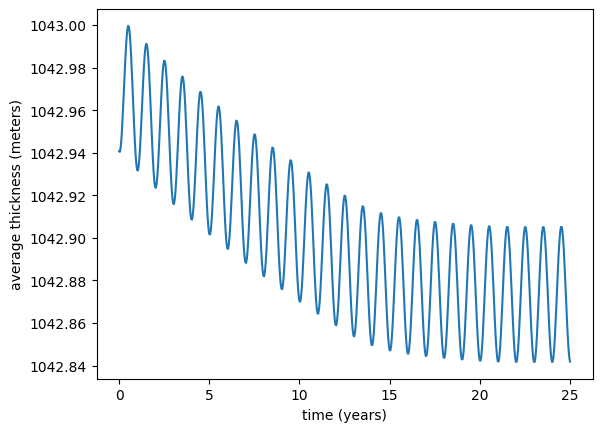

In [12]:
import matplotlib.pyplot as plt

average_thicknesses = np.array([firedrake.assemble(h * dx) / (Lx * Ly) for h in hs])
times = np.linspace(0, final_time, num_steps + 1)

fig, ax = plt.subplots()
ax.set_xlabel("time (years)")
ax.set_ylabel("average thickness (meters)")
ax.plot(times, average_thicknesses);

### Hindcasting

We're now going to see if we can recover the state of the system at time $t = 23.5$ from knowledge of the system state at time $t = 25$.
The biggest departure in this notebook from the previous demonstration of statistical estimation problems is that now our simulation includes a full loop over all timesteps, rather than a single diagnostic solve.
The simulation has to take in the controls (the unknown initial thickness) and return the observables (the final thickness).
There are a few extra variables, like the start and end times and the mean and fluctuations of the accumulation rate, that come in implicitly but aren't actual function arguments.

In [13]:
start_time = 23.5
final_time = 25.0

def simulation(h_initial):
    a = firedrake.Function(Q2)
    h = h_initial.copy(deepcopy=True)
    s = icepack.compute_surface(thickness=h, bed=z_b)
    u = flow_solver.diagnostic_solve(
        velocity=us[-1].copy(deepcopy=True),
        thickness=h,
        surface=s,
        fluidity=A,
        friction=C,
    )
    t = Constant(start_time)

    num_steps = int((final_time - start_time) / dt)
    for step in tqdm.trange(num_steps):
        t = Constant(t + dt)
        a.interpolate(a_0 + δa * firedrake.sin(2 * π * t))

        h = flow_solver.prognostic_solve(
            dt,
            thickness=h,
            velocity=u,
            accumulation=a,
            thickness_inflow=h_in,
        )
        s = icepack.compute_surface(thickness=h, bed=z_b)

        u = flow_solver.diagnostic_solve(
            velocity=u,
            thickness=h,
            surface=s,
            fluidity=A,
            friction=C,
        )

    return h

The loss functional calculates how well the final thickness and velocity from the simulation matches that from the actual time series.

In [14]:
def loss_functional(h_final):
    σ_h = Constant(1.0)
    return 0.5 / area * ((h_final - hs[-1]) / σ_h)**2 * dx

In the previous demonstration of inverse methods, we used a prior that favored a smooth value of the fluidity:

$$R(\theta) = \frac{\alpha^2}{2}\int_\Omega|\nabla\theta|^2dx.$$

Here we have a little more knowledge; while the initial state might depart somewhat from the final state, we expect the difference between the two to be fairly smooth.
So we'll instead use the prior

$$R(h(t_0)) = \frac{\alpha^2}{2}\int_\Omega|\nabla(h(t_1) - h(t_0))|^2dx.$$

In [15]:
def regularization(h_initial):
    α = Constant(0.0)
    δh = h_initial - hs[-1]
    return 0.5 * α**2 / area * inner(grad(δh), grad(δh)) * dx

As our starting guess for the initial thickness, we'll assume that it's equal to the final thickness.

In [16]:
h_initial = hs[-1].copy(deepcopy=True)

We've added a few extra options to pass to the optimizer in order to guarantee convergence to the right solution.

In [17]:
from icepack.statistics import (
    StatisticsProblem,
    MaximumProbabilityEstimator,
)

stats_problem = StatisticsProblem(
    simulation=simulation,
    loss_functional=loss_functional,
    regularization=regularization,
    controls=h_initial,
)

estimator = MaximumProbabilityEstimator(
    stats_problem,
    algorithm="bfgs",
    memory=10,
    gradient_tolerance=1e-12,
    step_tolerance=5e-14,
)

In [18]:
h_min = estimator.solve()

ConvergenceError: Nonlinear solve failed to converge after 2 nonlinear iterations.
Reason:
   DIVERGED_TR_DELTA

The minimizer is appreciably different from the thickness at $t = 25.0$ and very to the value at $t = 23.5$, so the algorithm has reproduced the initial condition that we pretended not to know.

In [19]:
δh_end = h_min - hs[-1]
print(f"|h_min - h(25.0)|: {firedrake.norm(δh_end)}")
num_steps = int((final_time - start_time) / dt)
δh_start = h_min - hs[-1 - num_steps]
print(f"|h_min - h(23.5)|: {firedrake.norm(δh_start)}")

NameError: name 'h_min' is not defined

In [20]:
import icepack.plot

δh = interpolate(h_min - hs[-1 - num_steps], Q2)
fig, axes = icepack.plot.subplots()
axes.set_title("Estimated - True thickness")
colors = firedrake.tripcolor(
    δh, vmin=-0.002, vmax=+0.002, cmap="RdBu", axes=axes
)
fig.colorbar(colors, fraction=0.01, pad=0.046);

NameError: name 'h_min' is not defined

### Conclusion

In previous demos, we've shown how use measurements of observable fields, like ice velocity and thickness, to estimate unknown parameters that satisfy constraints from a physics model.
The physics model was fairly rudimentary before -- taking in a single field like the ice fluidity and returning the ice velocity as computed from the momentum conservation equation.
Here we showed how to use much more complex simulations involving a full timestepping loop.
Instead of estimating an unobservable parameter of the system, like the fluidity or friction coefficient, we instead showed how to estimate the thickness at a different time from when it was observed.

Solving these kinds of problems is more computationally expensive and finding better or faster algorithms is an active area of research.
While costly, the capability does open up many more possible research directions and improvements on existing practice.
For example, when estimating the ice fluidity or friction, it's common to assume that the thickness and velocity measurements were taken at the same time.
This assumption is almost never exactly true.
The ability to do time-dependent data assimilation means that we can dispense with it.